In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import network
import config

In [5]:
normalized_scan_100206 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalized_scan_100206_full.npy")

In [6]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [7]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]

In [8]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]

In [9]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices_100206]

In [10]:
normalized_scan_100206_no_b5.shape

(935442, 270)

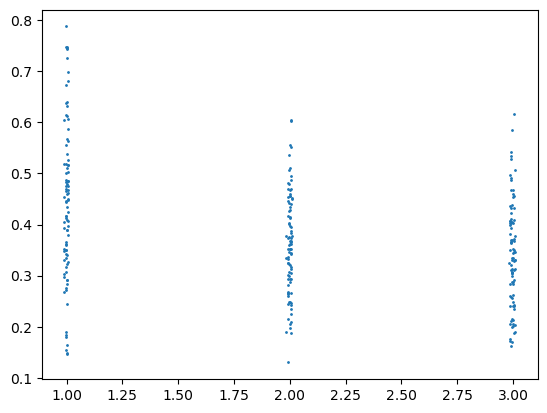

In [11]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [12]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206 = n_all_100206[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

(270, 3)


In [13]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [15]:
net_golden_std = network.BallStickNet(gradient_directions_100206, b_values_100206)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
criterion = nn.MSELoss()
optimizer = optim.Adam(net_golden_std.parameters(), lr = 0.00001)

In [19]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net_golden_std.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net_golden_std(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net_golden_std.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net_golden_std.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.42it/s]


Loss: 402.17272231564857
Average Loss: 0.055031844870778404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.87it/s]


Loss: 402.4628991386853
Average Loss: 0.05507155160627878
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.99it/s]


Loss: 402.2200996277388
Average Loss: 0.055038327808940725
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.41it/s]


Loss: 402.4087040789891
Average Loss: 0.055064135752461565
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.07it/s]


Loss: 402.14876933326013
Average Loss: 0.05502856723224687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.40it/s]


Loss: 402.28299305564724
Average Loss: 0.05504693391566054
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.04it/s]


Loss: 402.261157511035
Average Loss: 0.05504394601957238
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.10it/s]


Loss: 402.3064770363271
Average Loss: 0.05505014737771307
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.47it/s]


Loss: 402.06192127405666
Average Loss: 0.05501668326136517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.22it/s]


Loss: 402.2030750201084
Average Loss: 0.055035998223879085
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|███                                                                                                                                                           | 140/7308 [00:02<00:45, 157.66it/s]

X_batch: 
torch.Size([128, 270])
tensor([[1.2934, 0.5885, 0.5708,  ..., 0.4609, 0.4144, 0.3330],
        [0.0934, 0.0627, 0.0528,  ..., 0.1200, 0.0424, 0.0278],
        [0.6885, 0.3105, 0.1058,  ..., 0.4889, 0.4523, 0.2953],
        ...,
        [0.2851, 0.4995, 0.1675,  ..., 0.3446, 0.2552, 0.4244],
        [0.3810, 0.1642, 0.1752,  ..., 0.3872, 0.1653, 0.0827],
        [0.4476, 0.2795, 0.1410,  ..., 0.5110, 0.2454, 0.1397]])
X_pred: 
torch.Size([128, 270])
tensor([[0.5771, 0.3926, 0.3618,  ..., 0.5789, 0.4156, 0.3487],
        [0.1140, 0.0418, 0.0354,  ..., 0.1127, 0.0455, 0.0380],
        [0.5518, 0.4166, 0.0429,  ..., 0.4396, 0.3951, 0.3992],
        ...,
        [0.4330, 0.5768, 0.1516,  ..., 0.3691, 0.2970, 0.5376],
        [0.3492, 0.1547, 0.1139,  ..., 0.3428, 0.1703, 0.0931],
        [0.4883, 0.2662, 0.1449,  ..., 0.5008, 0.2416, 0.1592]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.02it/s]


Loss: 402.22263698955067
Average Loss: 0.055038675012253784
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.64it/s]


Loss: 402.26821686537005
Average Loss: 0.05504491199580871
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.33it/s]


Loss: 402.2373794692103
Average Loss: 0.05504069231926796
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.67it/s]


Loss: 402.07679351232946
Average Loss: 0.05501871832407355
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.41it/s]


Loss: 402.02177653321996
Average Loss: 0.05501119000180897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.94it/s]


Loss: 402.01524358731695
Average Loss: 0.0550102960573778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.21it/s]


Loss: 402.2334929755889
Average Loss: 0.05504016050569087
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.17it/s]


Loss: 401.9668528821785
Average Loss: 0.055003674450216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.70it/s]


Loss: 402.0315185333602
Average Loss: 0.05501252306148881
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.99it/s]


Loss: 402.1532480167225
Average Loss: 0.0550291800789166
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.48it/s]


Loss: 402.2072958231438
Average Loss: 0.05503657578313407
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.92it/s]


Loss: 401.9950858207885
Average Loss: 0.055007537742308224
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.79it/s]


Loss: 402.1250817128457
Average Loss: 0.05502532590487763
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.09it/s]


Loss: 402.19915691949427
Average Loss: 0.05503546208531668
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.90it/s]


Loss: 402.1645735036582
Average Loss: 0.05503072981713987
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.51it/s]


Loss: 402.1111184335314
Average Loss: 0.05502341522078973
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.98it/s]


Loss: 402.16832442348823
Average Loss: 0.05503124307929505
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.93it/s]

Loss: 402.03324630716816
Average Loss: 0.05501275948373949
Done, best loss: 401.9668528821785
Done


<All keys matched successfully>

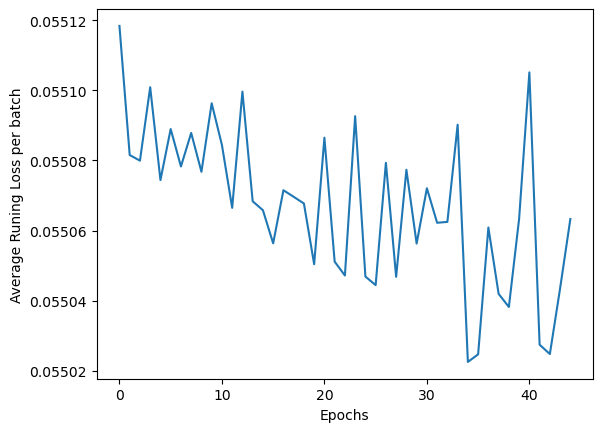

In [18]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()